In [1]:
import pandas as pd
import numpy as np
import librosa
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.metrics import classification_report
from lightgbm import LGBMClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [2]:
def train_with_10fold(model, name, data_dir='../data/pca'):
    accuracies = []
    all_preds = []
    all_labels = []

    for test_id in range(10):
        dfs = []
        for i in range(10):
            if i != test_id:
                df = pd.read_csv(f'{data_dir}/fold{i}.csv')
                dfs.append(df)
        train_df = pd.concat(dfs, ignore_index=True)
        test_df = pd.read_csv(f'{data_dir}/fold{test_id}.csv')

        # X, y
        X_train, y_train = train_df.drop('label', axis=1), train_df['label']
        X_test, y_test = test_df.drop('label', axis=1), test_df['label']

        # 訓練 & 評估
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        accuracies.append(acc)

        all_preds.extend(y_pred)
        all_labels.extend(y_test)

        print(f'Fold {test_id} Accuracy: {acc:.4f}')

    print(f'\nAverage Accuracy: {np.mean(accuracies):.4f}')
    print(f'Total: {len(all_labels)}')

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix (10-Fold CV) Using {name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    print(classification_report(all_labels, all_preds))

    return all_preds, all_labels


Fold 0 Accuracy: 0.5120
Fold 1 Accuracy: 0.4887
Fold 2 Accuracy: 0.5222
Fold 3 Accuracy: 0.5162
Fold 4 Accuracy: 0.5502
Fold 5 Accuracy: 0.5018
Fold 6 Accuracy: 0.5573
Fold 7 Accuracy: 0.5199
Fold 8 Accuracy: 0.6189
Fold 9 Accuracy: 0.5245

Average Accuracy: 0.5312
Total: 8732


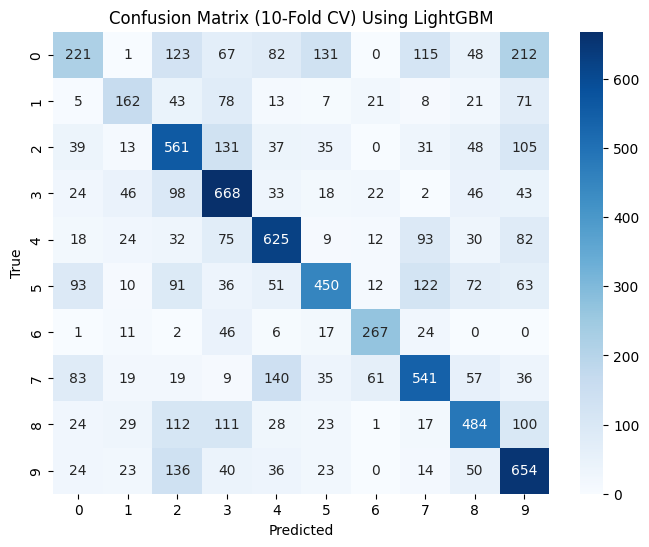

              precision    recall  f1-score   support

           0       0.42      0.22      0.29      1000
           1       0.48      0.38      0.42       429
           2       0.46      0.56      0.51      1000
           3       0.53      0.67      0.59      1000
           4       0.59      0.62      0.61      1000
           5       0.60      0.45      0.51      1000
           6       0.67      0.71      0.69       374
           7       0.56      0.54      0.55      1000
           8       0.57      0.52      0.54       929
           9       0.48      0.65      0.55      1000

    accuracy                           0.53      8732
   macro avg       0.54      0.53      0.53      8732
weighted avg       0.53      0.53      0.52      8732



In [ ]:
params = pickle.load(open('../models/LGBM_param_grid.pkl', 'rb'))

lgbm = LGBMClassifier(**params, verbose = -1)
all_preds, all_labels = train_with_10fold(lgbm, 'LightGBM')

In [6]:
label_dict = pickle.load(open('../data/label_dict.pkl', 'rb'))

In [7]:
from collections import Counter

pair_errors = [(t, p) for t, p in zip(all_labels, all_preds) if t != p]
counter = Counter(pair_errors)

_true, _miss, counts = [], [], []
for (true_label, pred_label), count in counter.most_common(10):
    _true.append(label_dict[true_label])
    _miss.append(label_dict[pred_label])
    counts.append(count)
    
misclassify = pd.DataFrame({
    'True': _true,
    'Pred': _miss,
    'Count': counts
})

misclassify


,True,Pred,Count
0,air_conditioner,street_music,212
1,jackhammer,drilling,140
2,street_music,children_playing,136
3,children_playing,dog_bark,131
4,air_conditioner,engine_idling,131
5,air_conditioner,children_playing,123
6,engine_idling,jackhammer,122
7,air_conditioner,jackhammer,115
8,siren,children_playing,112
9,siren,dog_bark,111


In [8]:
label_dict

{0: 'air_conditioner',
 1: 'car_horn',
 2: 'children_playing',
 3: 'dog_bark',
 4: 'drilling',
 5: 'engine_idling',
 6: 'gun_shot',
 7: 'jackhammer',
 8: 'siren',
 9: 'street_music'}

In [3]:
data = pd.read_csv('../data/orig/fold1.csv')
data.head()

,audio,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,...,rms,zcr,spectral_centroid,spectral_bandwidth,spectral_contrast,spectral_flatness,spectral_rolloff,chroma_stft,tonnetz,label
0,100652-3-0-0.wav,-272.629791,96.864433,-86.221619,-9.168318,4.169064,-16.863979,-13.483452,-0.150734,-6.587471,...,0.149369,0.050663,14.508313,11.031823,16.573282,16.990266,17.982048,22.439372,47.132530,3
1,100652-3-0-1.wav,-291.950104,100.772057,-94.797745,-11.993613,7.069183,-18.438421,-16.285732,-1.065854,-8.600836,...,0.153899,0.050825,11.756063,11.085855,17.376418,17.082429,18.396912,21.830608,46.550364,3
2,100652-3-0-2.wav,-300.354401,102.797256,-90.326263,-12.500052,9.068972,-20.856758,-16.338366,-2.211881,-5.525259,...,0.153786,0.045925,11.261134,10.677497,16.872774,16.129012,18.071604,22.392692,46.384113,3
3,100652-3-0-3.wav,-298.826080,103.677681,-94.644806,-13.064194,10.258672,-25.485121,-16.722870,-4.510607,-4.012282,...,0.148841,0.057532,11.405969,10.339423,18.361535,17.462183,18.773378,23.053206,46.480196,3
4,102104-3-0-0.wav,-598.363037,19.902557,-9.869736,0.639030,-2.062945,-0.870911,-0.648469,-0.272575,1.551253,...,0.029215,0.004547,18.253661,18.082409,19.373968,19.033812,19.342572,19.494263,24.791093,3


In [4]:
folds = pickle.load(open('../data/folds.pkl', 'rb'))

ac_sample_name = data[data.label == 0].iloc[1].audio
street_sample_name = data[data.label == 9].iloc[0].audio

print(ac_sample_name)
print(street_sample_name)

sample_data_1 = folds[1][ac_sample_name]
sample_data_2 = folds[1][street_sample_name]

146690-0-0-100.wav
14387-9-0-11.wav


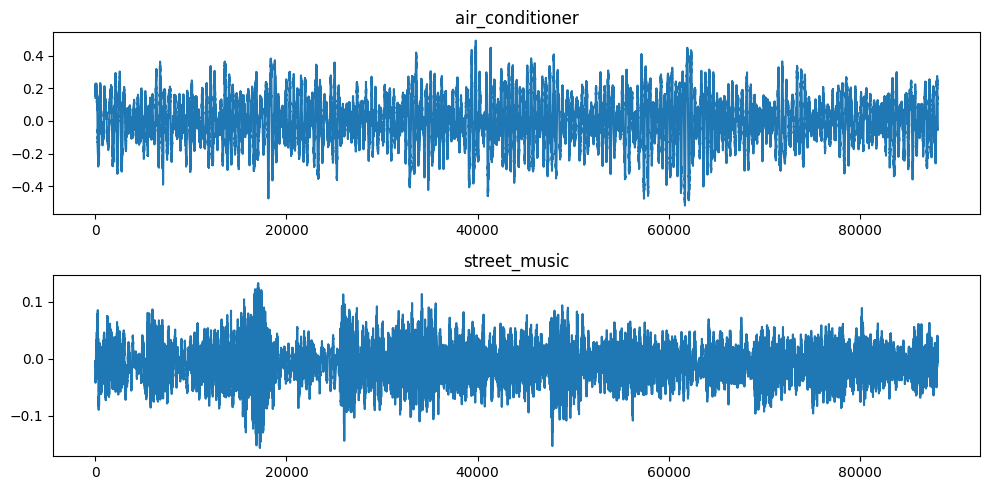

In [15]:
plt.figure(figsize=(10, 5))

plt.subplot(2, 1, 1)
plt.plot(sample_data_1['data'])
plt.title(label_dict[sample_data_1['label']])

plt.subplot(2, 1, 2)
plt.plot(sample_data_2['data'])
plt.title(label_dict[sample_data_2['label']])

plt.tight_layout()

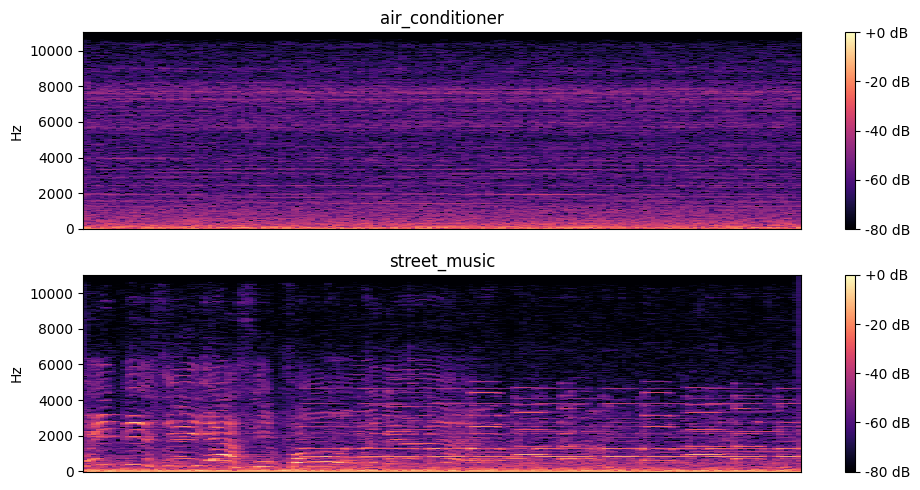

In [16]:
plt.figure(figsize=(10, 5))

plt.subplot(2, 1, 1)
D = librosa.amplitude_to_db(np.abs(librosa.stft(sample_data_1['data'])), ref=np.max)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title(label_dict[sample_data_1['label']])

plt.subplot(2, 1, 2)
D = librosa.amplitude_to_db(np.abs(librosa.stft(sample_data_2['data'])), ref=np.max)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title(label_dict[sample_data_2['label']])

plt.tight_layout()

In [5]:
drilling_sample_name = data[data.label == 4].iloc[0].audio
hammer_sample_name = data[data.label == 7].iloc[20].audio

print(drilling_sample_name)
print(hammer_sample_name)

sample_data_1 = folds[1][drilling_sample_name]
sample_data_2 = folds[1][hammer_sample_name]

104817-4-0-0.wav
169098-7-0-6.wav


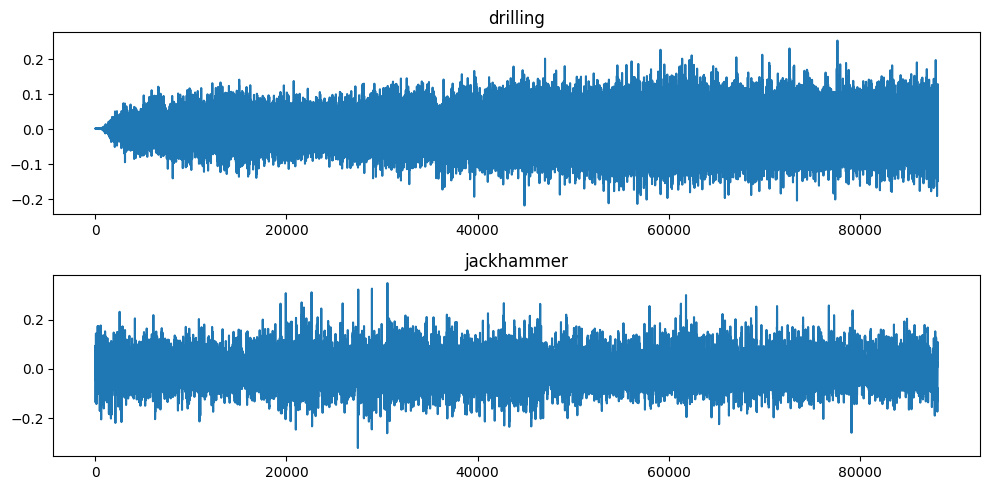

In [43]:
plt.figure(figsize=(10, 5))

plt.subplot(2, 1, 1)
plt.plot(sample_data_1['data'])
plt.title(label_dict[sample_data_1['label']])

plt.subplot(2, 1, 2)
plt.plot(sample_data_2['data'])
plt.title(label_dict[sample_data_2['label']])

plt.tight_layout()

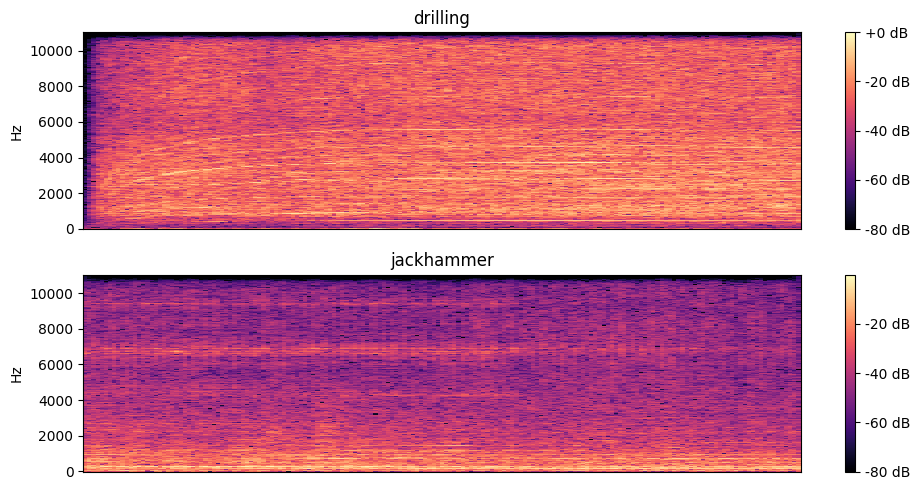

In [44]:
plt.figure(figsize=(10, 5))

plt.subplot(2, 1, 1)
D = librosa.amplitude_to_db(np.abs(librosa.stft(sample_data_1['data'])), ref=np.max)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title(label_dict[sample_data_1['label']])

plt.subplot(2, 1, 2)
D = librosa.amplitude_to_db(np.abs(librosa.stft(sample_data_2['data'])), ref=np.max)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title(label_dict[sample_data_2['label']])

plt.tight_layout()

In [52]:
dog_sample_name = data[data.label == 3].iloc[1].audio
children_sample_name = data[data.label == 2].iloc[0].audio
siren_sample_name = data[data.label == 8].iloc[0].audio
street_sample_name = data[data.label == 9].iloc[0].audio

sample_data_1 = folds[5][children_sample_name]
sample_data_2 = folds[5][dog_sample_name]
sample_data_3 = folds[5][siren_sample_name]
sample_data_4 = folds[5][street_sample_name]

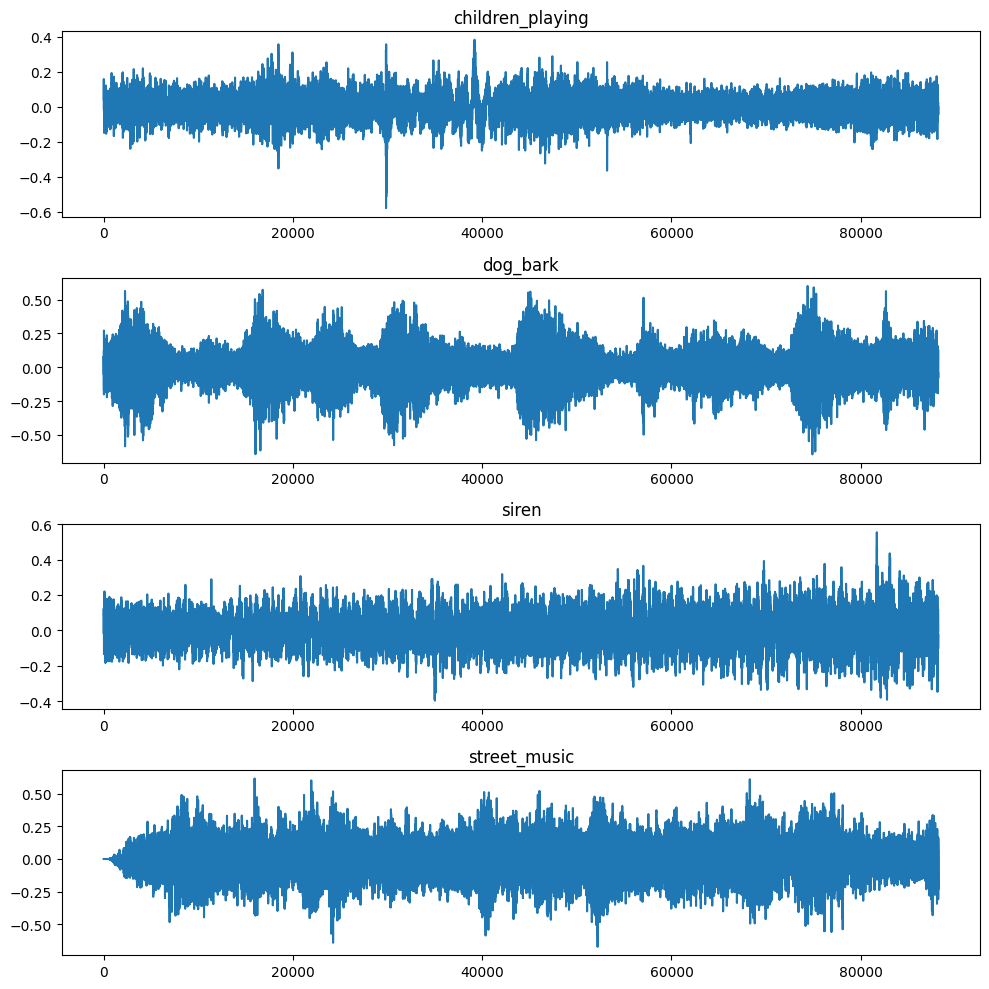

In [53]:
plt.figure(figsize=(10, 10))

plt.subplot(4, 1, 1)
plt.plot(sample_data_1['data'])
plt.title(label_dict[sample_data_1['label']])

plt.subplot(4, 1, 2)
plt.plot(sample_data_2['data'])
plt.title(label_dict[sample_data_2['label']])

plt.subplot(4, 1, 3)
plt.plot(sample_data_3['data'])
plt.title(label_dict[sample_data_3['label']])

plt.subplot(4, 1, 4)
plt.plot(sample_data_4['data'])
plt.title(label_dict[sample_data_4['label']])

plt.tight_layout()

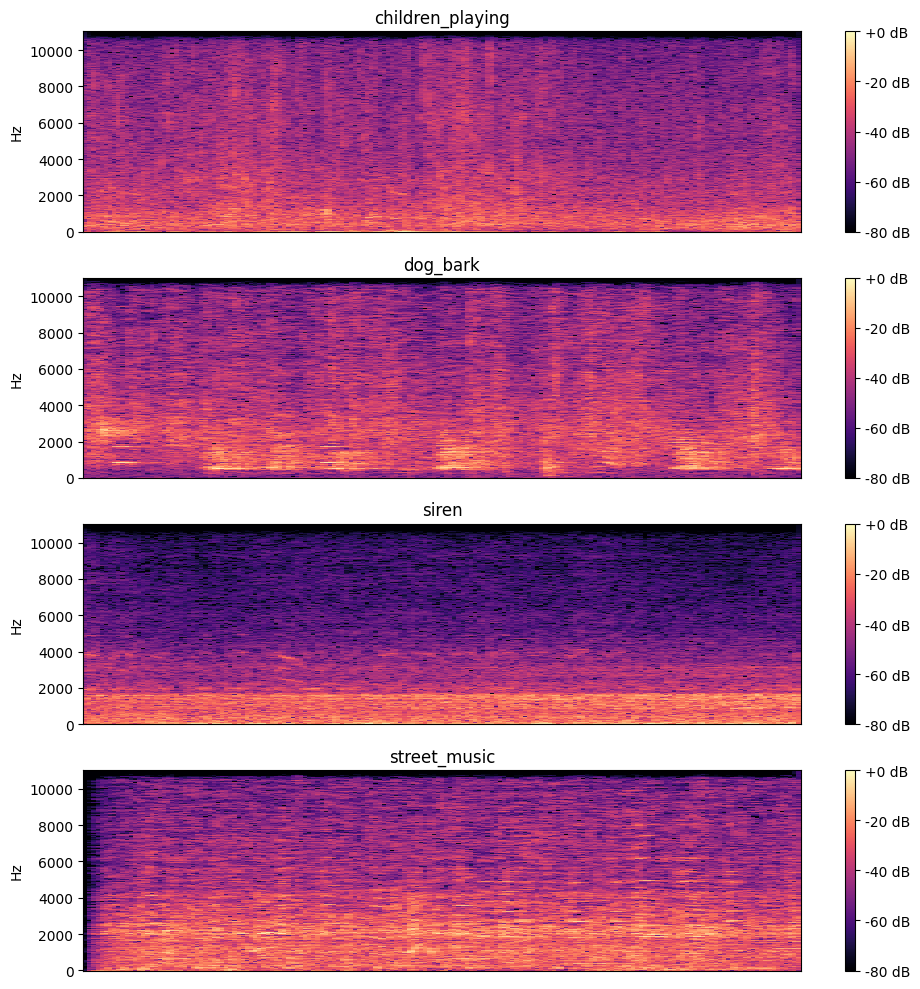

In [54]:
plt.figure(figsize=(10, 10))

plt.subplot(4, 1, 1)
D = librosa.amplitude_to_db(np.abs(librosa.stft(sample_data_1['data'])), ref=np.max)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title(label_dict[sample_data_1['label']])

plt.subplot(4, 1, 2)
D = librosa.amplitude_to_db(np.abs(librosa.stft(sample_data_2['data'])), ref=np.max)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title(label_dict[sample_data_2['label']])

plt.subplot(4, 1, 3)
D = librosa.amplitude_to_db(np.abs(librosa.stft(sample_data_3['data'])), ref=np.max)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title(label_dict[sample_data_3['label']])

plt.subplot(4, 1, 4)
D = librosa.amplitude_to_db(np.abs(librosa.stft(sample_data_4['data'])), ref=np.max)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title(label_dict[sample_data_4['label']])

plt.tight_layout()